In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [103]:
import ast
from fastprogress import progress_bar
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
from skimage import io, transform
import re
import urllib.request

from preprocess import load, generator
from utils import plot_labelled_image, plot_labelled_sample

In [150]:
all_data = pd.read_json(
    'https://content.mytalkingpet.app/templates?_start=0&_limit=8'
)

# 'https://content.mytalkingpet.app/templates?_limit=100&_sort=createdAt:DESC'

all_data = all_data[[
    'uploadedImage',
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]]

kp_cols = [
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]

all_data = all_data.dropna()

def get_floats(string):
    p = re.compile(r'\d+\.\d+') 
    
    # TODO get regex working for both floats and ints but not overlapping
    
    return p.findall(string)

def split_array(array):
    print(array)
    return array[0], array[1]

for col in kp_cols:
    all_data[col] = all_data[col].apply(get_floats)
    print(col)
    all_data[col+'_y'], all_data[col+'_x'] = zip(*all_data[col].map(split_array))
    
    all_data = all_data.drop(col, axis=1)

uploadImageDf = pd.DataFrame(all_data['uploadedImage'].values.tolist())
all_data['hash'] = uploadImageDf['hash'].values

In [151]:
all_data

,uploadedImage,leftHeadPoint,leftEarPoint,topHeadPoint,rightEarPoint,rightHeadPoint,chinPoint,leftEyePoint,rightEyePoint,leftMouthPoint,centreMouthPoint,rightMouthPoint
1,"{'_id': '5d400e64632e71001db07a40', 'name': 'Z...","[174.93333333333334, 330.24000000000001]","[165.54666666666665, 552.10666666666668]","[338.77333333333331, 456.5333333333333]","[513.70666666666671, 539.30666666666662]",[],"[332.80000000000001, 133.97333333333336]","[255.14666666666668, 319.14666666666665]","[407.89333333333332, 315.73333333333335]","[296.95999999999998, 168.95999999999998]","[326.82666666666665, 186.02666666666664]","[368.63999999999999, 173.22666666666669]"
2,"{'_id': '5d400e94cdaf490019ddfdda', 'name': 'i...","[165.54666666666665, 296.10666666666668]","[6.4000000000000004, 500.05333333333334]","[346.45333333333332, 479.57333333333332]","[616.10666666666668, 537.60000000000002]",[],"[408.74666666666667, 133.12]","[304.63999999999999, 341.33333333333331]","[477.86666666666667, 356.69333333333333]","[407.04000000000002, 170.66666666666669]","[450.56, 184.31999999999999]","[482.98666666666668, 178.34666666666669]"
3,"{'_id': '5d400f21632e71001db07a44', 'name': 'M...","[251.73333333333332, 230.39999999999998]","[240.63999999999999, 354.13333333333333]","[349.86666666666667, 320.85333333333335]","[480.42666666666668, 344.74666666666667]","[473.60000000000002, 254.29333333333335]","[360.10666666666668, 157.01333333333332]","[308.90666666666669, 255.14666666666665]","[421.54666666666668, 250.88]","[349.86666666666667, 181.75999999999999]","[369.49333333333334, 187.73333333333335]",[180.90666666666669]
4,"{'_id': '5d400f31632e71001db07a48', 'name': '5...","[157.86666666666667, 293.54666666666668]","[150.18666666666667, 505.17333333333335]","[346.45333333333332, 471.03999999999996]","[517.97333333333336, 547.84000000000003]","[572.5866666666667, 280.74666666666667]","[367.78666666666669, 132.26666666666665]","[264.53333333333336, 300.37333333333333]","[453.12, 322.56]","[337.06666666666666, 191.14666666666665]","[364.37333333333333, 244.05333333333334]","[403.62666666666667, 193.70666666666665]"
5,"{'_id': '5d400f40cdaf490019ddfddd', 'name': 'D...","[214.18666666666667, 394.24000000000001]","[184.31999999999999, 515.4133333333333]","[306.34666666666669, 498.34666666666669]","[406.18666666666667, 514.55999999999995]","[410.45333333333332, 393.38666666666666]","[321.70666666666665, 264.53333333333336]","[270.50666666666666, 377.17333333333335]","[358.39999999999998, 390.82666666666665]","[293.54666666666668, 269.65333333333331]","[319.14666666666665, 281.60000000000002]","[348.16000000000003, 273.92000000000002]"


In [83]:
for i in progress_bar(range(all_data.shape[0])):
    urllib.request.urlretrieve(
        all_data.iloc[i]['uploadedImage']['url'], 
        "../data/uploaded_images/{}.png".format(all_data.iloc[i]['hash'])
    )

In [84]:
all_data = all_data.drop('uploadedImage', axis=1)

def add_png(hashes):
    return hashes + '.png'

all_data['hash'] = all_data['hash'].apply(add_png)

In [85]:
all_data.head()

,leftHeadPoint_y,leftHeadPoint_x,leftEarPoint_y,leftEarPoint_x,topHeadPoint_y,topHeadPoint_x,rightEarPoint_y,rightEarPoint_x,rightHeadPoint_y,rightHeadPoint_x,...,leftEyePoint_x,rightEyePoint_y,rightEyePoint_x,leftMouthPoint_y,leftMouthPoint_x,centreMouthPoint_y,centreMouthPoint_x,rightMouthPoint_y,rightMouthPoint_x,hash
1,174.933333,330.240000,165.546667,552.106667,338.773333,456.533333,539.306667,513.706667,320.000000,512.000000,...,319.146667,407.893333,315.733333,168.960000,296.960000,326.826667,186.026667,173.226667,368.640000,0ea9acd5d49445fdbcfda219e5cb07a0.png
2,165.546667,296.106667,6.400000,500.053333,479.573333,346.453333,537.600000,616.106667,320.000000,512.000000,...,304.640000,477.866667,356.693333,407.040000,170.666667,450.560000,184.320000,482.986667,178.346667,a13788b48cef41bc8f526e1a60cb966c.png
3,230.400000,251.733333,354.133333,240.640000,349.866667,320.853333,344.746667,480.426667,254.293333,473.600000,...,308.906667,421.546667,250.880000,181.760000,349.866667,187.733333,369.493333,180.906667,384.000000,c912c68a3e874d879960666b71eefe8f.png
4,157.866667,293.546667,150.186667,505.173333,471.040000,346.453333,517.973333,547.840000,572.586667,280.746667,...,264.533333,453.120000,322.560000,191.146667,337.066667,244.053333,364.373333,403.626667,193.706667,6809a523a7eb410bb9109e256dc51675.png
5,214.186667,394.240000,515.413333,184.320000,498.346667,306.346667,406.186667,514.560000,410.453333,393.386667,...,377.173333,358.400000,390.826667,293.546667,269.653333,319.146667,281.600000,348.160000,273.920000,7fb5867617684df39fbe2be2ddff926d.png


In [80]:
all_data = all_data[[
    'leftHeadPoint_x', 'leftHeadPoint_y',
    'leftEarPoint_x', 'leftEarPoint_y',
    'topHeadPoint_x', 'topHeadPoint_y',
    'rightEarPoint_x', 'rightEarPoint_y',
    'rightHeadPoint_x', 'rightHeadPoint_y',
    'chinPoint_x', 'chinPoint_y', 
    'leftEyePoint_x', 'leftEyePoint_y',
    'rightEyePoint_x', 'rightEyePoint_y', 
    'leftMouthPoint_x', 'leftMouthPoint_y', 
    'centreMouthPoint_x', 'centreMouthPoint_y',
    'rightMouthPoint_x', 'rightMouthPoint_y', 
    'hash'
]]

all_data.rename(
    columns={
        'leftHeadPoint_x': '0_x', 'leftHeadPoint_y': '0_y',
        'leftEarPoint_x': '1_x', 'leftEarPoint_y': '1_y',
        'topHeadPoint_x': '2_x', 'topHeadPoint_y': '2_y',
        'rightEarPoint_x': '3_x', 'rightEarPoint_y': '3_y',
        'rightHeadPoint_x': '4_x', 'rightHeadPoint_y': '4_y',
        'chinPoint_x': '5_x', 'chinPoint_y': '5_y',
        'leftEyePoint_x': '6_x', 'leftEyePoint_y': '6_y',
        'rightEyePoint_x': '7_x', 'rightEyePoint_y': '7_y',
        'leftMouthPoint_x': '8_x', 'leftMouthPoint_y': '8_y',
        'centreMouthPoint_x': '9_x', 'centreMouthPoint_y': '9_y',
        'rightMouthPoint_x':'10_x', 'rightMouthPoint_y':'10_y',
        'hash': 'filename'
    }, 
    inplace=True
) 

In [81]:
all_data.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y,filename
1,330.240000,174.933333,552.106667,165.546667,456.533333,338.773333,513.706667,539.306667,512.000000,320.000000,...,255.146667,315.733333,407.893333,296.960000,168.960000,186.026667,326.826667,368.640000,173.226667,0ea9acd5d49445fdbcfda219e5cb07a0
2,296.106667,165.546667,500.053333,6.400000,346.453333,479.573333,616.106667,537.600000,512.000000,320.000000,...,341.333333,356.693333,477.866667,170.666667,407.040000,184.320000,450.560000,178.346667,482.986667,a13788b48cef41bc8f526e1a60cb966c
3,251.733333,230.400000,240.640000,354.133333,320.853333,349.866667,480.426667,344.746667,473.600000,254.293333,...,255.146667,250.880000,421.546667,349.866667,181.760000,369.493333,187.733333,384.000000,180.906667,c912c68a3e874d879960666b71eefe8f
4,293.546667,157.866667,505.173333,150.186667,346.453333,471.040000,547.840000,517.973333,280.746667,572.586667,...,300.373333,322.560000,453.120000,337.066667,191.146667,364.373333,244.053333,193.706667,403.626667,6809a523a7eb410bb9109e256dc51675
5,394.240000,214.186667,184.320000,515.413333,306.346667,498.346667,514.560000,406.186667,393.386667,410.453333,...,270.506667,390.826667,358.400000,269.653333,293.546667,281.600000,319.146667,273.920000,348.160000,7fb5867617684df39fbe2be2ddff926d


In [60]:
all_data.to_csv('../data/uploaded_labels.csv', index=False)

In [61]:
images_path = '../data/images/'
labels_path = '../data/landmarks.csv'
target_size = 640

images_path = '../data/uploaded_images/'
labels_path = '../data/uploaded_labels.csv'
target_size = 640

In [62]:
X, y = load(images_path, labels_path, target_size)

In [63]:
y.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
0ea9acd5d49445fdbcfda219e5cb07a0.png,330.240000,174.933333,552.106667,165.546667,456.533333,338.773333,513.706667,539.306667,512.000000,320.000000,...,319.146667,255.146667,315.733333,407.893333,296.960000,168.960000,186.026667,326.826667,368.640000,173.226667
a13788b48cef41bc8f526e1a60cb966c.png,296.106667,165.546667,500.053333,6.400000,346.453333,479.573333,616.106667,537.600000,512.000000,320.000000,...,304.640000,341.333333,356.693333,477.866667,170.666667,407.040000,184.320000,450.560000,178.346667,482.986667
c912c68a3e874d879960666b71eefe8f.png,251.733333,230.400000,240.640000,354.133333,320.853333,349.866667,480.426667,344.746667,473.600000,254.293333,...,308.906667,255.146667,250.880000,421.546667,349.866667,181.760000,369.493333,187.733333,384.000000,180.906667
6809a523a7eb410bb9109e256dc51675.png,293.546667,157.866667,505.173333,150.186667,346.453333,471.040000,547.840000,517.973333,280.746667,572.586667,...,264.533333,300.373333,322.560000,453.120000,337.066667,191.146667,364.373333,244.053333,193.706667,403.626667
7fb5867617684df39fbe2be2ddff926d.png,394.240000,214.186667,184.320000,515.413333,306.346667,498.346667,514.560000,406.186667,393.386667,410.453333,...,377.173333,270.506667,390.826667,358.400000,269.653333,293.546667,281.600000,319.146667,273.920000,348.160000


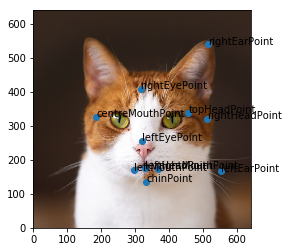

In [68]:
filename = '0ea9acd5d49445fdbcfda219e5cb07a0.png'

fig, ax = plt.subplots()
ax.imshow(np.flipud(np.array(Image.open(images_path+filename))), origin='lower')
ax.scatter(y.loc[filename][0::2], y.loc[filename][1::2])

xs = y.loc[filename][0::2]
ys = y.loc[filename][1::2]
cols = [
    'leftHeadPoint', 
    'leftEarPoint',
    'topHeadPoint',
    'rightEarPoint',
    'rightHeadPoint',
    'chinPoint',
    'leftEyePoint',
    'rightEyePoint',
    'leftMouthPoint',
    'centreMouthPoint',
    'rightMouthPoint'
]
for i in range(11):
    ax.annotate(cols[i], (xs[i], ys[i]))

In [65]:
y.loc[filename]

0_x     330.240000
0_y     174.933333
1_x     552.106667
1_y     165.546667
2_x     456.533333
2_y     338.773333
3_x     513.706667
3_y     539.306667
4_x     512.000000
4_y     320.000000
5_x     332.800000
5_y     133.973333
6_x     319.146667
6_y     255.146667
7_x     315.733333
7_y     407.893333
8_x     296.960000
8_y     168.960000
9_x     186.026667
9_y     326.826667
10_x    368.640000
10_y    173.226667
Name: 0ea9acd5d49445fdbcfda219e5cb07a0.png, dtype: float64

In [32]:
y.head()

,0_x,0_y,1_x,1_y,2_x,2_y,3_x,3_y,4_x,4_y,...,6_x,6_y,7_x,7_y,8_x,8_y,9_x,9_y,10_x,10_y
filename,,,,,,,,,,,,,,,,,,,,,
baa6f42058d44f05977e2a91bb6d85b1.png,128,320.0,128,576,306.086957,444.186811,512,576,512,320.0,...,256,384,384,384,224,268.8,266.924323,300.933962,224,371.2
3c9b3114833141aa9758fe8ca4ddc101.png,340,166.0,224,638,348.000000,509.000000,544,604,360,513.0,...,371,270,448,344,252,302.0,346.000000,245.000000,251,398.0
e744036fcaa94fbc9c0da05a24626a12.png,128,429.4,128,576,320.000000,515.400000,512,576,433,429.4,...,504,307,509,389,336,365.0,224.000000,371.200000,373,431.0


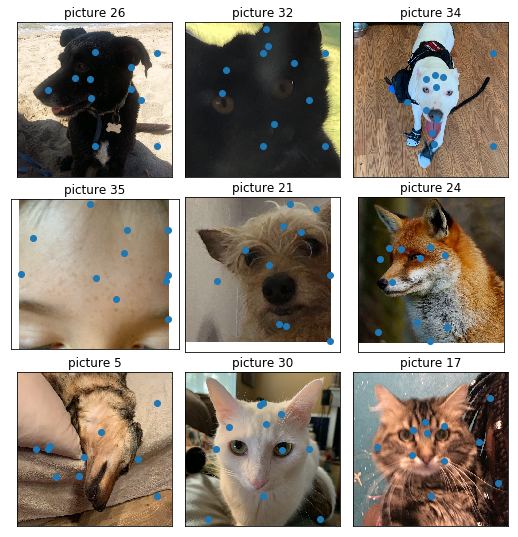

In [125]:
plot_labelled_sample(X, y, target_size, False)

In [ ]:
# TODO 
# Get the proprocessing step working for the uploaded data, maybe pass the all_data df to resize()
# Adapt the hand kp tracking for the faces